In [1]:
import os, sys

import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from utils.utils import Create_Similarity_Model

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

sns.set_style('whitegrid')
sns.set_context("talk")

2022-07-27 14:30:58.111782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 14:30:58.111798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Now we will create our model

In [2]:
n_nonsimilar = 1
n_similar = 1

## Fabricate our data simulating the laminar flow

In [3]:
possible_re_tau = np.linspace(start = 1, stop = 100, num = 100)
Re_tau = []
Y_ =[]
U_ = []
dic_x = {}
dic_y = {}

for re_tau in possible_re_tau:
    possible_y_= np.linspace(start = 0.1, stop = re_tau, num = 100)
    for y_ in possible_y_:
        Y_.append(y_)
        Re_tau.append(re_tau)
        u_ = y_ - ((1 / (2*re_tau)) * ((y_) ** 2))
        U_.append(u_)

Y_ = np.log(Y_)
Re_tau = np.log(Re_tau)

dic_x['y+'] = Y_
dic_x['re_tau'] = Re_tau
dic_y['u+'] = U_


nonsimilar_keys = ['y+']

xtrain = pd.DataFrame.from_dict(dic_x).values
ytrain = pd.DataFrame.from_dict(dic_y).values

In [4]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
n_fits = 5                       # Number of model fits we will try to perform
n_epochs_initial = 10           # Number of epochs we will train inside the loop
n_epochs_final = 1000          # Number of epochs we will train after convergence is established
successfull_tries = 0

while successfull_tries < n_fits:
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    print("current loss:" + str(current_loss))
    if current_loss < 100:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        print(good_loss)
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

2022-07-27 14:31:04.598045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 14:31:04.598451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-27 14:31:04.598510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-27 14:31:04.598557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-27 14:31:04.598608: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

current loss:451.5191955566406
current loss:2.0935914516448975
0.0002448992745485157
current loss:451.5191955566406
current loss:451.5191955566406
current loss:451.5191955566406
current loss:0.026917411014437675
0.0021922970190644264
current loss:0.17472907900810242


KeyboardInterrupt: 

In [5]:
for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer_' + str(i+1)).weights[0][0].numpy()
    print('Exponents multiplicating inside the function for ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function: ' + str(multiplication_exponents))

Exponents multiplicating inside the function for y+: [-0.999654]
Exponents multiplicating outside the function: [0.999759]


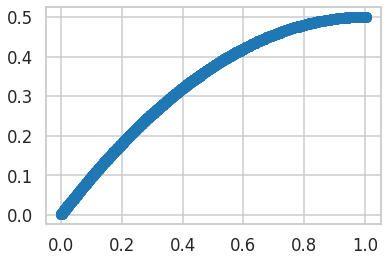

In [6]:
Y__ = np.exp(Y_)
Re_tau__ = np.exp(Re_tau)

plt.scatter(Y__ * (Re_tau__ ** similarity_exponents), U_ / (Re_tau__ ** multiplication_exponents))

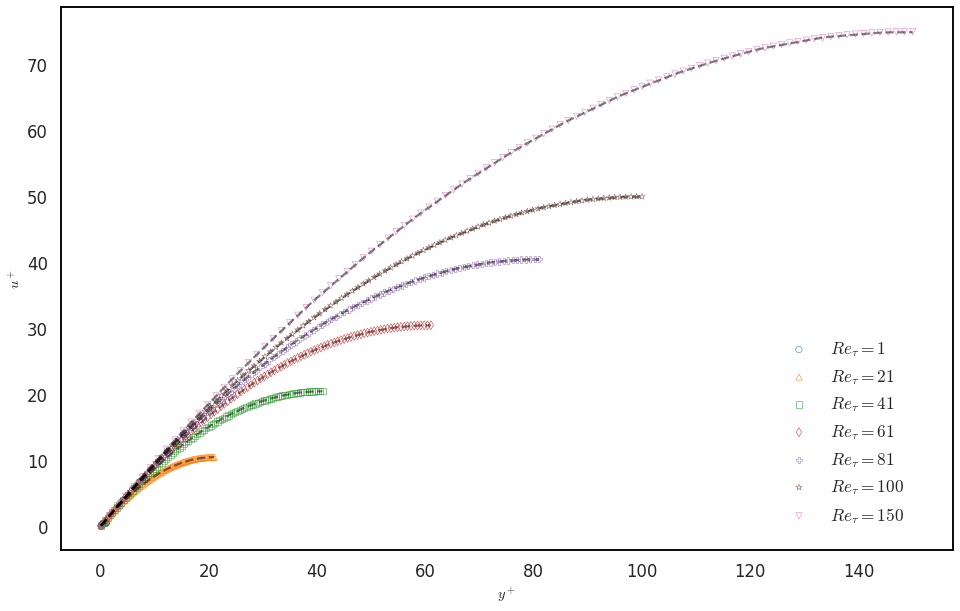

In [7]:
possible_re_tau = list(possible_re_tau)
possible_re_tau.append(150)
possible_re_tau = np.array(possible_re_tau)
selection = [0, 20, 40, 60, 80, 99, 100]

fig, ax1 = plt.subplots(figsize=(16, 10))

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in selection:
    Y_ = []
    Re_tau = []
    U_ = []
    re_tau = possible_re_tau[i]
    possible_y_= np.linspace(start = 0.1, stop = re_tau, num = 100)
    for y_ in possible_y_:
        Y_.append(y_)
        Re_tau.append(re_tau)
        U_.append(y_ - ((1 / (2*re_tau)) * ((y_) ** 2)))
    Y_ = np.log(Y_)
    Re_tau = np.log(Re_tau)

    dic_x['y+'] = Y_
    dic_x['re_tau'] = Re_tau

    xtest = pd.DataFrame.from_dict(dic_x).values
    pred = best_model.predict(xtest, verbose = 0)
    ax1.plot(np.exp(Y_), pred, color = 'k', alpha = 0.5, linestyle = 'dashed')
    ax1.scatter(np.exp(Y_), U_, s=40 , linewidth = line_width , facecolors='none', color = colors[j], marker = markers[j%len(markers)], label = r'$Re_\tau= $'+r'${:.0f}$'.format(possible_re_tau[i]))
    j +=1


font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(bbox_to_anchor=(0.8, 0.4), loc = 'upper left', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$y^+$", size = 'x-large')
ax1.set_ylabel(r'$u^+$', size = 'x-large')
#ax1.set_ylim([2,15])
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.savefig('Figures/BarenNet prediction for Laminar Similarity.pdf', format='pdf', dpi=1200)
plt.show()
    